# Milestone 2

# 1 - Introduction

Name: `Bandoro, FTDS 013`


Objective: 
`Classify the types of brain tumor based on MRI results using Convolutional Neural Network`

Dataset URL:
`Brain Tumor Classification (MRI) ( https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri )`
- frontend URL: https://frontend-tumor-classifier-ml2.herokuapp.com/
- backend URL: https://backend-tumor-classifier-ml2.herokuapp.com/


# 2 - Import Libraries

In [56]:
# below are the libraries that I use

import os
import cv2
import io
import glob
import numpy as np
from numpy import expand_dims
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten
from IPython.display import display,clear_output
from IPython.core.pylabtools import figsize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import ipywidgets as widgets
from google.colab import files
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import warnings
warnings.filterwarnings('ignore')

# 3 - Data Loading and Initial Preprocessing

In [ ]:
# Create a folder directory in kaggle root

!mkdir -p ~/.kaggle 

# copy kaggle.json to kaggle root directory

!cp kaggle.json ~/.kaggle 

# create kaggle folder in the same location

!mkdir ./kaggle 

# moving the kaggle.json to kaggle folder in the same location

!mv ./kaggle.json ./kaggle 

#configuring access permission

!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
# Download the dataset using kaggle API command

!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

# unzipping the data

!unzip -q /content/brain-tumor-classification-mri.zip

# move Training and Testing folder to brain-tumor-classification-mri directory

!mkdir ./brain-tumor-classification-mri 
!mv ./Training ./brain-tumor-classification-mri 
!mv ./Testing ./brain-tumor-classification-mri 

 93% 81.0M/86.8M [00:00<00:00, 109MB/s]
100% 86.8M/86.8M [00:00<00:00, 107MB/s]


In [ ]:
# observe total amount of images

main_path = '/content/brain-tumor-classification-mri'

image_count = len(glob.glob(main_path+ '/*/*/*.jpg'))
print("Total Images: ", image_count)
print("")

train_path = os.path.join(main_path, 'Training')
test_path = os.path.join(main_path, 'Testing')

print('Train Set (total: {})'.format(len(glob.glob(train_path+ '/*/*.jpg'))))
print('='*50)
print('no_tumor: ', len(glob.glob(train_path+ '/no_tumor/*.jpg')))
print('glioma_tumor: ', len(glob.glob(train_path+ '/glioma_tumor/*.jpg')))
print('meningioma_tumor: ', len(glob.glob(train_path+ '/meningioma_tumor/*.jpg')))
print('pituitary_tumor: ', len(glob.glob(train_path+ '/pituitary_tumor/*.jpg')))

print('')

print('Test Set (total: {})'.format(len(glob.glob(test_path+ '/*/*.jpg'))))
print('='*50)
print('no_tumor: ', len(glob.glob(test_path+ '/no_tumor/*.jpg')))
print('glioma_tumor: ', len(glob.glob(test_path+ '/glioma_tumor/*.jpg')))
print('meningioma_tumor: ', len(glob.glob(test_path+ '/meningioma_tumor/*.jpg')))
print('pituitary_tumor: ', len(glob.glob(test_path+ '/pituitary_tumor/*.jpg')))

Total Images:  3264

Train Set (total: 2870)
no_tumor:  395
glioma_tumor:  826
meningioma_tumor:  822
pituitary_tumor:  827

Test Set (total: 394)
no_tumor:  105
glioma_tumor:  100
meningioma_tumor:  115
pituitary_tumor:  74


The dataset we use is consisted of 3264 images, with 2870 (86%) images for train and 394 (14%) images for test. The images themselves are divided into 4 categories: no_tumor, glioma_tumor, meningioma_tumor, and pituitary tumor. 

We see that 14% proportion for test data is relatively small compared to the standard practice which is 20% (https://www.r-bloggers.com/2021/01/what-is-a-good-test-set-size/). Also we can see that the proportion of each class are not equal between the train and test set ('no_tumor' class has the lowest proportion in test set, while in the test set, 'pituitary_tumor' served as the lowest).

In such case, I'll try to increase the amount of test data while at the same time reorganizing the distribution. I'll achieve this by first creating a dataframe, shuffle all the data, and re-splitting the data using train test split. This process is expected to increase the representativeness of test result, also removing the bias of initial train/test arrangement.

In [ ]:
# defining a function to create dataframe

def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2], plt.imread(image).shape[0], plt.imread(image).shape[1], plt.imread(image).shape[2])) # creating a list of tuples
    return pd.DataFrame(data, columns=['images', 'label', 'height', 'width','depth'])

In [ ]:
# create the dataframe

train_data = glob.glob(train_path+ '/*/*.jpg')
test_data = glob.glob(test_path+ '/*/*.jpg')

df = create_dataframe(train_data + test_data)
df = df.sample(frac=1, random_state=32).reset_index(drop=True) #reshuffle the data
df

,images,label,height,width,depth
0,/content/brain-tumor-classification-mri/Traini...,glioma_tumor,512,512,3
1,/content/brain-tumor-classification-mri/Traini...,glioma_tumor,512,512,3
2,/content/brain-tumor-classification-mri/Traini...,meningioma_tumor,512,512,3
3,/content/brain-tumor-classification-mri/Traini...,glioma_tumor,512,512,3
4,/content/brain-tumor-classification-mri/Traini...,no_tumor,848,785,3
...,...,...,...,...,...
3259,/content/brain-tumor-classification-mri/Traini...,glioma_tumor,512,512,3
3260,/content/brain-tumor-classification-mri/Testin...,no_tumor,252,236,3
3261,/content/brain-tumor-classification-mri/Traini...,meningioma_tumor,221,228,3
3262,/content/brain-tumor-classification-mri/Traini...,meningioma_tumor,512,512,3


In [ ]:
# train test split 

train_df_full, test_df = train_test_split(df, test_size=0.2, random_state=5, stratify = df['label'])

print("Train shape: ",train_df_full.shape)
print("Test shape: ", test_df.shape)

Train shape:  (2611, 5)
Test shape:  (653, 5)


In [ ]:
# show the amount of new data arrangement

print("Total Images: ", len(df))
print("")

print("Train Set total:", len(train_df_full), f"({len(train_df_full)/len(df)*100}%)" )
print('='*50)
print('no_tumor: ', len(train_df_full[train_df_full['label']== 'no_tumor']))
print('glioma_tumor: ', len(train_df_full[train_df_full['label']== 'glioma_tumor']))
print('meningioma_tumor: ', len(train_df_full[train_df_full['label']== 'meningioma_tumor']))
print('pituitary_tumor: ', len(train_df_full[train_df_full['label']== 'pituitary_tumor']))

print('')

print("Test Set total:", len(test_df), f"({len(test_df)/len(df)*100}%)" )
print('='*50)
print('no_tumor: ', len(test_df[test_df['label']== 'no_tumor']))
print('glioma_tumor: ', len(test_df[test_df['label']== 'glioma_tumor']))
print('meningioma_tumor: ', len(test_df[test_df['label']== 'meningioma_tumor']))
print('pituitary_tumor: ', len(test_df[test_df['label']== 'pituitary_tumor']))

Total Images:  3264

Train Set total: 2611 (79.99387254901961%)
no_tumor:  400
glioma_tumor:  741
meningioma_tumor:  749
pituitary_tumor:  721

Test Set total: 653 (20.006127450980394%)
no_tumor:  100
glioma_tumor:  185
meningioma_tumor:  188
pituitary_tumor:  180


Now, we see that the data proportion is more equally distributed than before.

# 4 - Exploratory Data Analysis (EDA)

In [ ]:
# Observe the minimum value of pixel height and width

print('Minimum height : ', train_df_full.height.min())
print('Minimum width : ', train_df_full.width.min())


Minimum height :  167
Minimum width :  174


We can see that the pixel height and width have a minimum value around 160, this will be put as a consideration to determine the input size later as we don't want to determine input that has higher pixel values than the images we have.

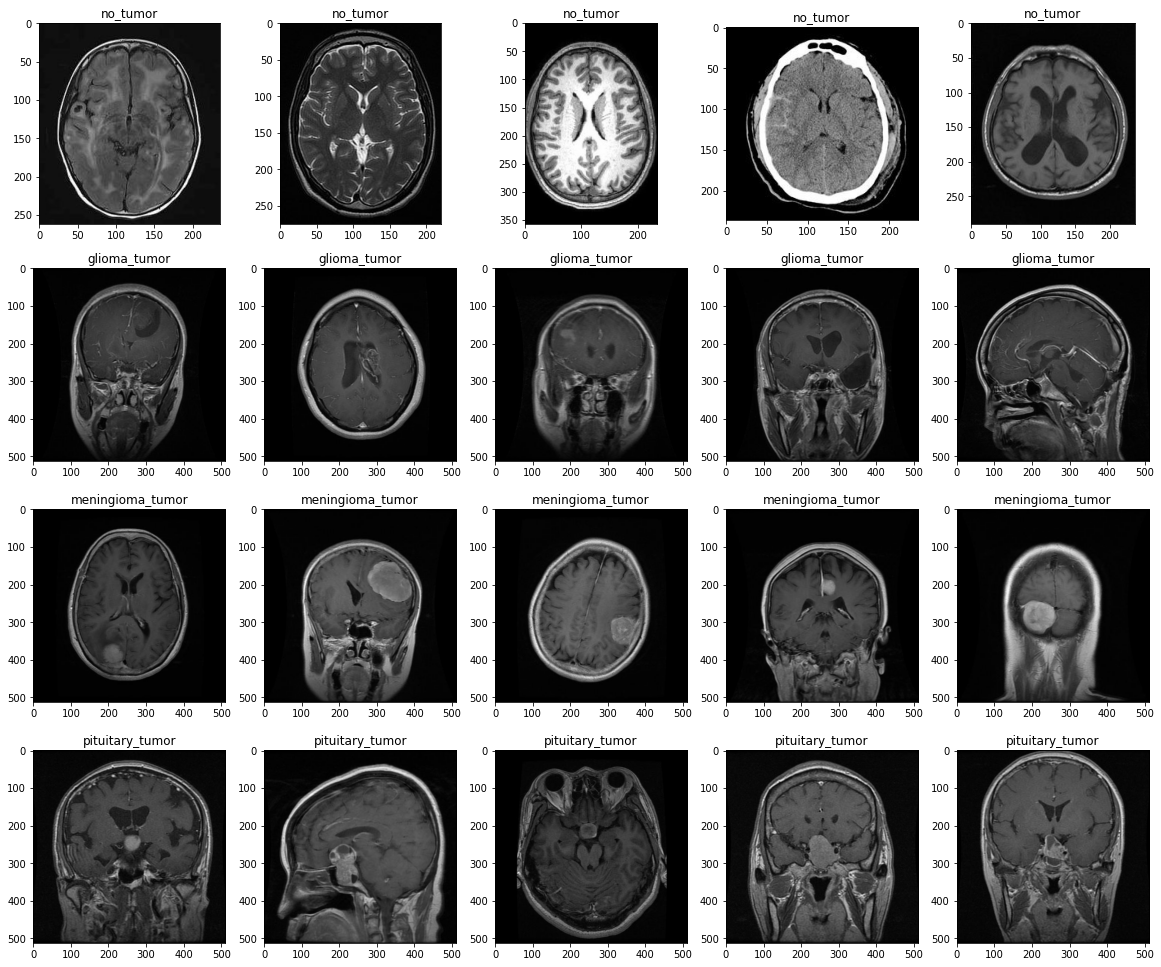

In [ ]:
# Get 5 samples for all the classes 

no_tumor_samples = (train_df_full[train_df_full['label']=="no_tumor"]['images'].iloc[:5]).tolist()
glioma_tumor_samples = (train_df_full[train_df_full['label']=='glioma_tumor']['images'].iloc[:5]).tolist()
meningioma_tumor_samples = (train_df_full[train_df_full['label']=='meningioma_tumor']['images'].iloc[:5]).tolist()
pituitary_tumor_samples = (train_df_full[train_df_full['label']=='pituitary_tumor']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20,17))
    for i, sample in enumerate(samples):
        img = plt.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(img)
    plt.show()

visualize_samples(no_tumor_samples + glioma_tumor_samples + meningioma_tumor_samples + pituitary_tumor_samples)

Each types of tumor has different characteristics. We can see that for glioma tumor, it has the characteristics of lower density (darker area) with some enhancement on the edge of the tumor. Whereas for meningioma, we can see more homogenous enhancement of higher contrast area. And we can differentiate the pituitary tumor by looking at the location of the tumor, which is on the middle base of the brain (since the pituitary itself is located there). As for this case, I can say that the dataset we have are aligned with what being proposed in the current theory (sources: http://www.aboutcancer.com/mri_gbm.htm, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4397140/ ).

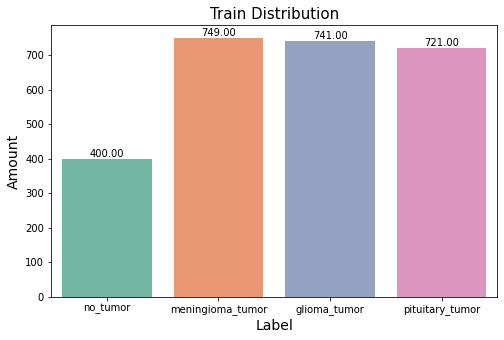

In [ ]:
# visualize label proportion (Train)

def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Amount", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=15)
    plt.show()

visualize_data(train_df_full, 'Train')

We see that in our train data, all types of tumor have more or less balanced distribution except for 'no_tumor' class (about a half less than the other classes). The lack amount of data might lead to bias in the model prediction, such as, the model can predict an image with no tumor as if it's having the attributes of tumor. In the next process, I'll try to minimize this bias tendency by augmenting the train data. 

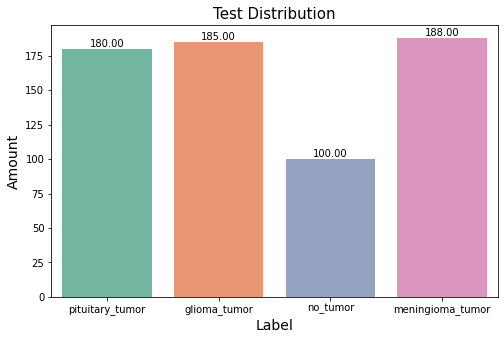

In [76]:
# visualize label proportion (Test)

visualize_data(test_df, 'Test')

Test set has similar proportionality to the train set, with no_tumor class proportion around a half less than the other classes.

Text(0.5, 1.0, 'Average Image Size ')

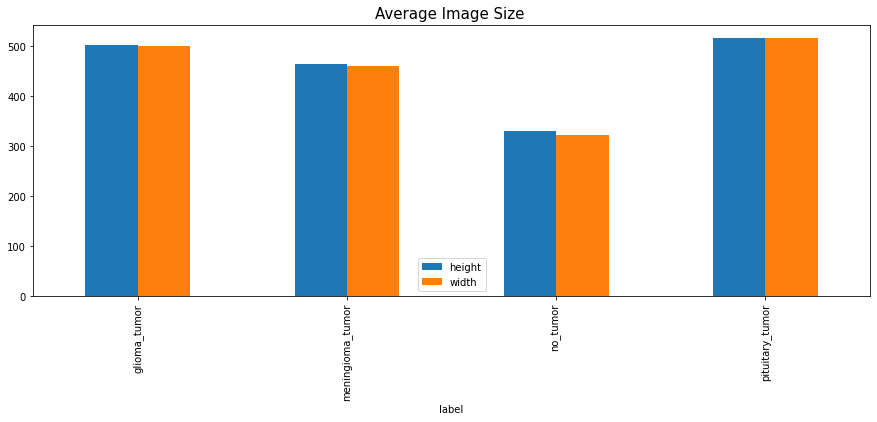

In [89]:
# observe the average image size for each class

train_df_full.groupby('label')[['height', 'width']].mean().plot(kind='bar', figsize=(15,5))
plt.title("Average Image Size ", size=15)

We see that the normal brain MRI (no_tumor) image are smaller in average, whereas the other class are more or less similar in size.

# 5 - Data Preprocessing

## Train-Validation split

In [ ]:
# Splitting train and validation set

train_df, val_df = train_test_split(train_df_full, test_size=0.2, random_state=4, stratify= train_df_full['label'])

print("Train shape: ", train_df.shape)
print("Val shape: ", val_df.shape)
print("Test shape: ", test_df.shape)

Train shape:  (2088, 5)
Val shape:  (523, 5)
Test shape:  (653, 5)


## Data augmentation

Data augmentation is performed so the model can learn from more variations of data. Below are the augmentation methods that I choose:

* Horizontal Flip: because the tumor can be either on the right or the left side.
* Random Rotation: because slight angle differences might occurs when the MRI images are taken.
* Random Zoom: Different patients have different head sizes (also the images can be taken by different MRI machines which differs in sizes), this will lead to variations of zooming ratios of the image results.
* Random Brightness: There're a lot of factors that can influence the brightness of the MRI results.

glioma_tumor


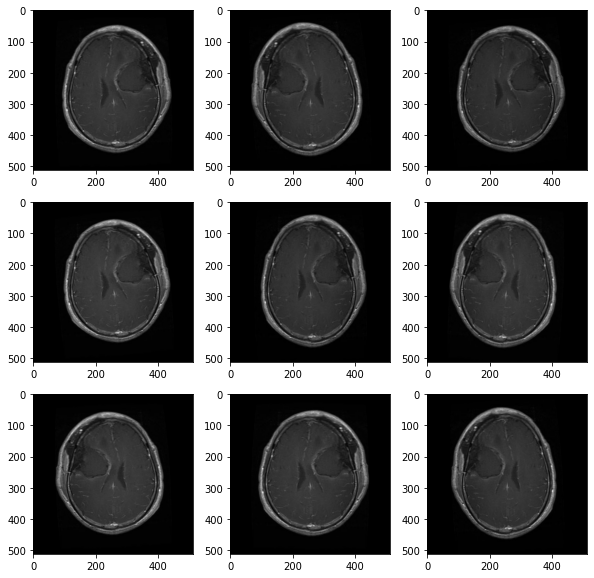

In [ ]:
# Show the illustration of data augmentation

img = load_img(train_df['images'].tolist()[13])
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

# create image data augmentation generator
datagen = ImageDataGenerator( 
    rotation_range=5, #apply 5 degrees of random rotation
    brightness_range=(0.9,1.1), 
    zoom_range=[0.95,1.05],
    horizontal_flip=True)

it = datagen.flow(samples, batch_size=1)

# generate samples and plot
plt.figure(figsize=(10, 10))
for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	plt.imshow(image)
 
# show the figure
print(train_df['label'].tolist()[13])
plt.show()

Below is the real ImageDataGenerator which will be used to augment the data. Note: Data augmentation methods which was described above will only be performed to the train set, as for the validation and test set, I'll only use rescalling method to normalize the pixel values. Since pixel values ranges between 0 and 255 (representing 8 bits of information), I'll use 255 as the scaling denominator.

In [ ]:
# create image data generator (including pixel normalization)

train_datagen = ImageDataGenerator( 
    rescale=1./255, 
    rotation_range=5, 
    brightness_range=(0.9,1.1),
    zoom_range=[0.95,1.05],
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# define some parameters of the loader

img_height = 160  
img_width = 160
batch_size = 32

In [ ]:
# create dataframe iterator

train_ds = train_datagen.flow_from_dataframe( 
    dataframe=train_df,                       
    x_col='images', 
    y_col='label',
    target_size=(img_height, img_width), 
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False) # I don't shuffle the data since it has been shuffled before

val_ds = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='sparse',
    batch_size=batch_size,
    shuffle= False) 

test_ds = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False) 

Found 2088 validated image filenames belonging to 4 classes.
Found 523 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.


In [ ]:
# showing class names

class_names = train_ds.class_indices
print('class names: ', class_names)

class names:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [ ]:
# observe if the image size and batch are align with what have been set

for image_batch, labels_batch in train_ds:
  print("Batch Images: ", image_batch.shape)
  print("Batch Label: ",labels_batch.shape)
  break

Batch Images:  (32, 160, 160, 3)
Batch Label:  (32,)


# 6 - Model Definition

In [ ]:
# Define the model

model = Sequential([
  keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape= (img_height, img_width, 3)),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(filters=32, kernel_size=3,padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(filters=64, kernel_size = 3,padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.4),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(4, activation='softmax', name="outputs")
])

Above, I'm Using a Convolutional Neural Network (CNN) with sequential API as my initial model, below are further explanations of the architecture:

* I chose three combinations of MaxPooling2D and Conv2D, where in Conv2D the initial pixel matrices will be filtered/convoluted by 3x3 kernel matrix (I pick kernel_size = 3), before get processed into relu activation function `f(x) = max(0,x)`. The filtered matrix is called as feature map, this feature map will laterwards get filtered futhermore by Max Pooling (which select the highest value in every 2x2 region of the matrix). The filters inside the Conv2D indicates the amount of feature map that will be produced in every step (I'm choosing 16, 32, and 62 increment on every step).
* The results of Conv2D and MaxPooling will get flattened into one dimensional matrix, before get normalized by BatchNormalization and processed by the Dense layer.
* Here I'm using one dense layer with 128 neurons. I also added 0.5 dropouts after it to prevent dying neurons which might reduce the probability of model overfitting. 

I'll use Adaptive Moment Estimation (Adam) as the optimizer because it has the component of 'momentum' and 'RMSProp' algorithm so it requires less memory and more efficient. Adam is also considered as the state-of-the-Art CNN optimizer for brain tumor classification in Magnetic Resonance Images (MRI), which is suitable for the case I'm working on right now (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7407771/). Since this is a multiclass classification and the label is not onehotencoded, I'm using sparse categorical crossentropy as the loss formula. 

In [ ]:
# complile the model

model.compile(optimizer= keras.optimizers.Adam(),
              loss= keras.losses.SparseCategoricalCrossentropy(),#from_logits=True),
              metrics=['accuracy'])

Below are the summary and visualization of my model:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0

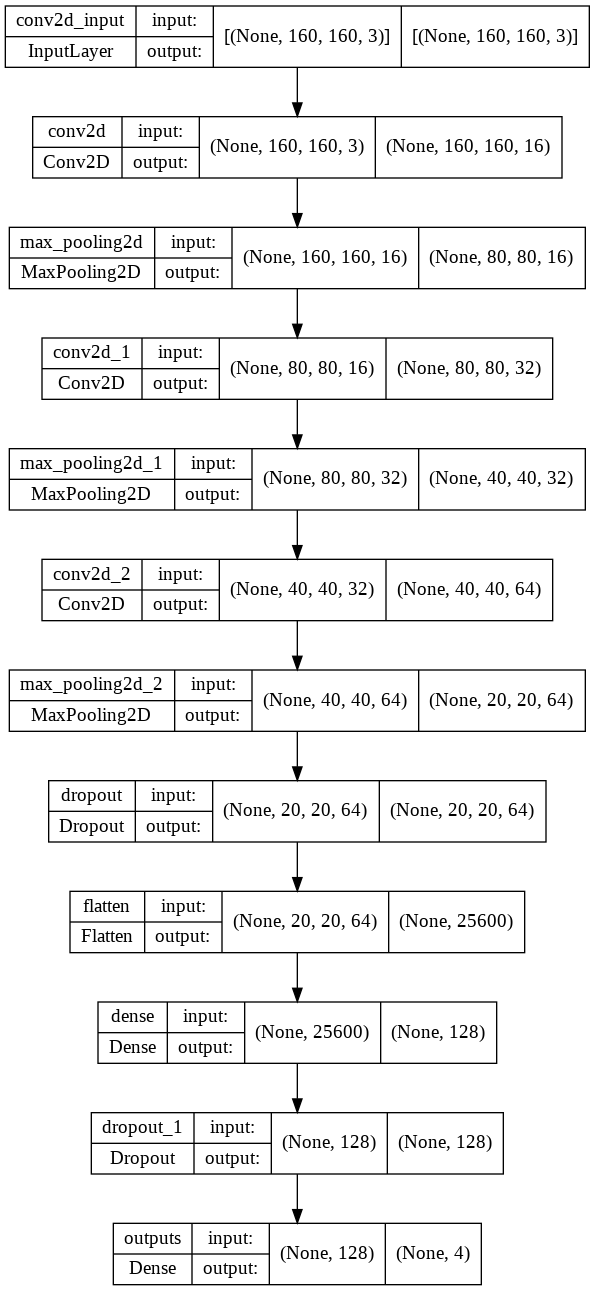

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

# 7 - Model Training

In [ ]:
# define callbacks 

callbacks1 = [ModelCheckpoint("model.h5",monitor="val_loss",verbose=1, save_best_only=True), 
              EarlyStopping(monitor = 'val_loss', patience = 5)]

These are the callbacks method I'm using:
* model checkpoint to save the best model.
* early stopping (patience=5) to stop running the epoch if val_loss doesn't improved after 5 epoch.

In [ ]:
# train the model

history = model.fit(train_ds, epochs =50, verbose=1, validation_data=val_ds,
                   callbacks=callbacks1)

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 1.1690 - accuracy: 0.4933
Epoch 1: val_loss improved from inf to 1.01299, saving model to model.h5
66/66 [==============================] - 30s 294ms/step - loss: 1.1690 - accuracy: 0.4933 - val_loss: 1.0130 - val_accuracy: 0.6023
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.9405 - accuracy: 0.6284
Epoch 2: val_loss improved from 1.01299 to 0.85078, saving model to model.h5
66/66 [==============================] - 19s 288ms/step - loss: 0.9405 - accuracy: 0.6284 - val_loss: 0.8508 - val_accuracy: 0.6444
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.8219 - accuracy: 0.6600
Epoch 3: val_loss improved from 0.85078 to 0.74992, saving model to model.h5
66/66 [==============================] - 19s 288ms/step - loss: 0.8219 - accuracy: 0.6600 - val_loss: 0.7499 - val_accuracy: 0.6960
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.7098
E

# 8 - Model Evaluation

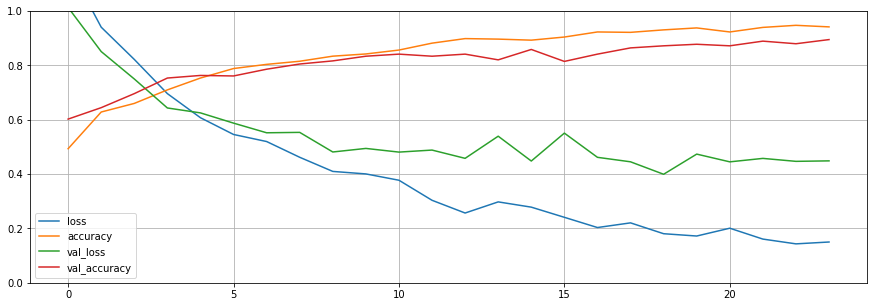

In [ ]:
# Graphing model performance on every epoch

pd.DataFrame(history.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

From the graph above, we can see that the training loss and acurracy are steadily improving on every epoch. Validation accuracy is increasing concurrently with the training accuracy, while for validation loss, it's more fluctuative and seemed to reach stagnation after 19th epoch (train_loss = 0.18, val_loss = 0.39), the stagnation caused the early stopping to be initialized on 24th epoch (patience = 5). Next, I'll evaluate the model performance with regard to the test data.

In [ ]:
# recalling class_indices

test_ds.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [ ]:
# evaluate model to test set 

train_pred = model.predict(train_ds)
train_pred = np.argmax(train_pred, axis = -1)
train_true = train_df['label']
train_true = np.array(train_true.replace({'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}))


test_pred = model.predict(test_ds)
test_pred = np.argmax(test_pred, axis = -1)
test_true = test_df['label']
test_true = np.array(test_true.replace({'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}))

print('Classification report (Train)')
print(classification_report(train_true, train_pred))

print('')

print('Classification report (Test)')
print(classification_report(test_true, test_pred))

Classification report (Train)
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       592
           1       0.97      0.98      0.98       599
           2       0.98      0.98      0.98       320
           3       0.99      0.99      0.99       577

    accuracy                           0.98      2088
   macro avg       0.98      0.98      0.98      2088
weighted avg       0.98      0.98      0.98      2088


Classification report (Test)
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       185
           1       0.91      0.85      0.88       188
           2       0.91      0.88      0.89       100
           3       0.94      0.99      0.97       180

    accuracy                           0.92       653
   macro avg       0.91      0.91      0.91       653
weighted avg       0.92      0.92      0.91       653



Since the model I created is addressed to predict various types of tumor (healthcare diagnostic problem), it's important to reduce the False Negative count as low as possible (ex: we don't want to induce wrong treatment by classifying a patient who has meningioma tumor as though it is a glioma tumor, or even worse we don't want to classify those who has tumor as normal). 

That's why in this particular case I'll evaluate the model using Recall score as the primary metric, this because Recall score itself is a good representation for the proportion of False Negatives (Recall = TP/ TP+FN).

Above, we can see that the model shows quite a promising performance in predicting glioma_tumor (class index: 0), no_tumor (class index: 2), and pituitary_tumor (class index: 3) (recall score is around 0.90 for both train and test set). However, when it comes to meningioma_tumor (class index: 1), we can see that the model shows inferior performance by overfitting to the train data (Recall Train: 0.98, Recall Test: 0.85). Let's dive deeper into this into this problem by looking at the confusion matrix below.

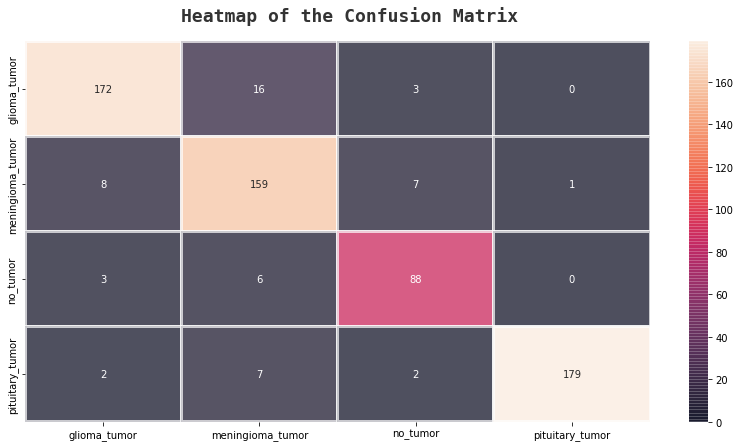

In [31]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(test_pred,test_true),ax=ax,xticklabels=labels,yticklabels=labels,annot=True
            ,alpha=0.7,linewidths=2, fmt="d")
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

Note: rows represent predicted class and columns represent true class

We can see at the confusion matrix above that out of 188 samples labeled as meningioma_tumor, only 159 are predicted accordingly, which means the rest 29 are falsely classified. Out of 29 meningioma samples which are wrongly classified, 16 are predicted as glioma tumor, 6 are predicted as no_tumor, and 7 as pituitary_tumor. This might indicate that our model have the tendency to misclassify meningioma_tumor as either glioma_tumor, pituitary_tumor, or no-tumor at all.

In the next step I'll try to use pretrained model in the hope that we can get a better result.

# 9 - Model Improvement

For the next step, I'll use the pretrained model Residual Network (ResNet50) for model improvement. This is a CNN that was introduced in 2016, and have shown state-of-the-art accuracy for many demanding image classification at ImageNet and MS COCO competition (Top 1 accuracy 74.9%, Top 5 accuracy 92.1%). 

The reason why I choose this model stemmed from the demonstration published by Krisna Nuresa Qodri,et.al.(IJITEE Journal University of Gajah Mada). The paper illustrates that compared to the other model (DenseNet192, Xception, NASNETLarge, VGG16, and VGG19), ResNet50 has shown the best overall performance on classifying MRI's results of Brain Tumors (train acc: 99%, val acc: 96%). This was a great result considering that the model itself wasn't initially trained to classify medical imaging data (source: https://jurnal.ugm.ac.id/ijitee/article/download/62663/31493 ). 

The first thing to be highlighted here is that the ResNet50 (from Keras API) expects a specific kind of input preprocessing which will convert the input images from RGB to BGR and zero-center each color channel with respect to the ImageNet dataset, without scaling. Also the model seemed to work best to the input shape of 224x224x3 ( https://keras.io/api/applications/resnet/#resnet50-function ). For that case, I'll first create a new data generator which fulfill those requirements.

In [ ]:
# define some parameters of the new loader

img_height2 = 224
img_width2 = 224
batch_size2 = 32

In [ ]:
# create new image data generator 

train_datagen2 = ImageDataGenerator( 
    #rescale=1./255, 
    rotation_range=5, 
    brightness_range=(0.9,1.1),
    zoom_range=[0.95,1.05],
    horizontal_flip=True)

val_datagen2 = ImageDataGenerator()#rescale=1./255)
test_datagen2 = ImageDataGenerator()#rescale=1./255)

In [32]:
# create dataframe iterator

train_ds2 = train_datagen2.flow_from_dataframe( 
    dataframe=train_df,                       
    x_col='images', 
    y_col='label',
    target_size=(img_height2, img_width2), 
    class_mode='sparse',
    batch_size=batch_size2,
    shuffle=False) # I don't shuffle the data since it has been shuffled before

val_ds2 = val_datagen2.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height2, img_width2),
    class_mode='sparse',
    batch_size=batch_size2,
    shuffle= False) 

test_ds2 = test_datagen2.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height2, img_width2),
    class_mode='sparse',
    batch_size=batch_size2,
    shuffle=False) 

Found 2088 validated image filenames belonging to 4 classes.
Found 523 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.


In [33]:
# showing class names

class_names = train_ds2.class_indices
print('class names: ', class_names)

class names:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [34]:
# observe if the image size and batch are align with what have been set

for image_batch, labels_batch in train_ds2:
  print("Batch Images: ", image_batch.shape)
  print("Batch Label: ",labels_batch.shape)
  break

Batch Images:  (32, 224, 224, 3)
Batch Label:  (32,)



Next, I'll import the ResNet50 model directly from keras API without including the top layer. I'm also going to add some extra layer before the output layer which are composed of flatten layer, 3 dense layer consisting 256-128-and-64 neurons respectively, while also adding batch normalization and dropout layer before and after every hidden layer.

In [36]:
# importing imagenet model (ResNet50)

pretrained_model = tf.keras.applications.ResNet50(weights='imagenet',include_top=False,
                                                        input_shape=(img_height2,img_width2,3))
pretrained_model.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [41]:
# observe the total layers of the pretrained model

print("Total layers of ResNet50: ", len(pretrained_model.layers))

Total layers of ResNet50:  175


In [42]:
# observe the components of ResNet50

pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

We can see that ResNet50 is consisted of 23.5 millions parameters, with the layers mostly comprised of convolutional2D, BatchNormalization, and it also uses relu as the activation function.

In [43]:
# create model architecture with functional API

inputs = keras.Input(shape= (img_height2, img_width2, 3))
x = keras.applications.resnet.preprocess_input(inputs)
x = pretrained_model(x) 
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(rate=0.8)(x)
x = keras.layers.BatchNormalization()(x)
x= keras.layers.Dense(128)(x)
x = keras.layers.Dropout(rate=0.7)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64)(x)
x = keras.layers.Dropout(rate=0.5)(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(4, activation='softmax')(x)
model_resnet = keras.Model(inputs, outputs)

In [44]:
# compiling the model

model_resnet.compile(optimizer = keras.optimizers.Adam(),loss=keras.losses.SparseCategoricalCrossentropy() , 
              metrics= ['accuracy'])

In [45]:
# observe the model summary

model_resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                               

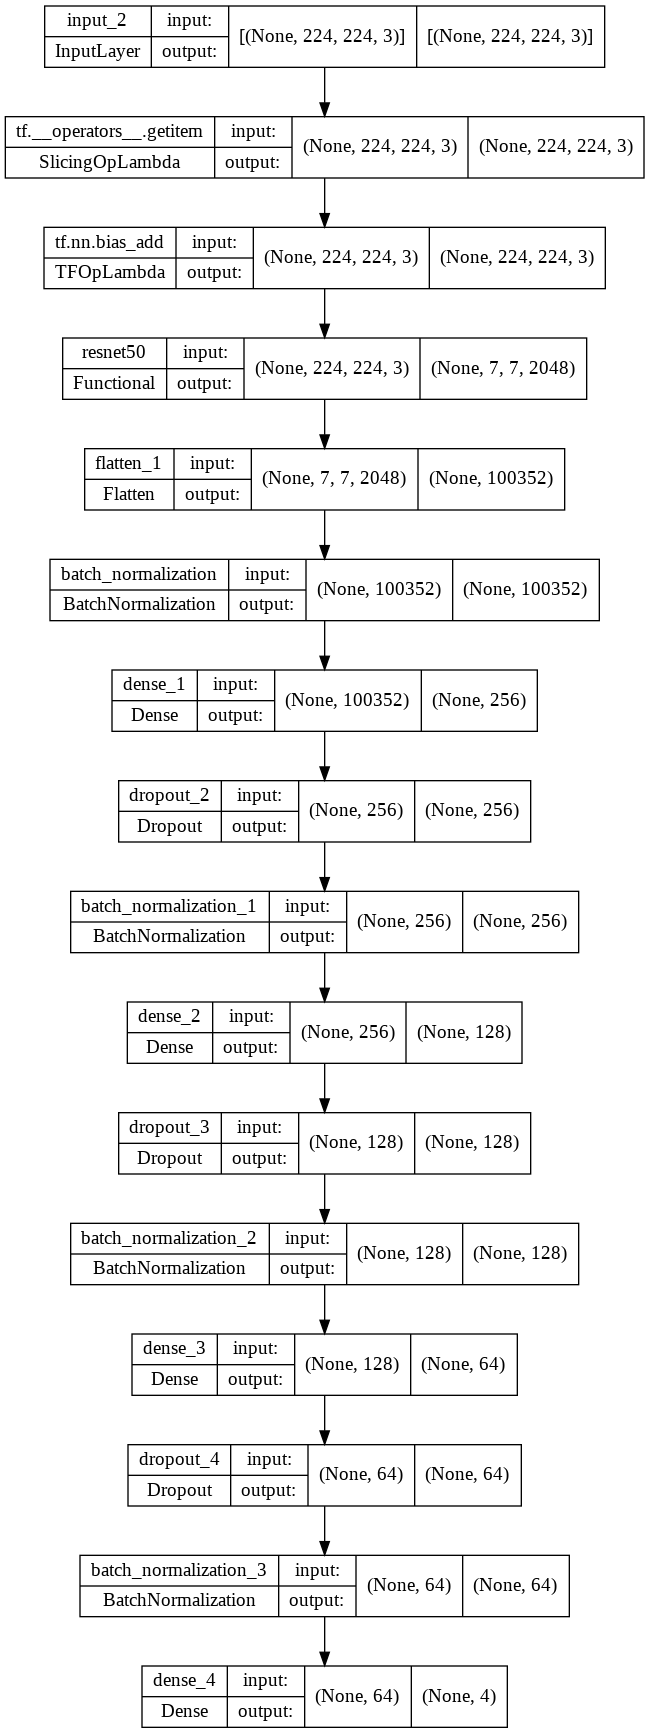

In [46]:
# visualize the model

tf.keras.utils.plot_model(model_resnet, show_shapes=True)

In [47]:
# define callbacks 

callbacks2 = [ModelCheckpoint("model_resnet.h5",monitor="val_loss",verbose=1, save_best_only=True), 
              EarlyStopping(monitor = 'val_loss', patience = 5)]

In [48]:
# train the model

history_resnet = model_resnet.fit(train_ds2, epochs =50, validation_data=val_ds2,
                   callbacks= callbacks2)

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 1.3985 - accuracy: 0.4368
Epoch 1: val_loss improved from inf to 1.27216, saving model to model_resnet.h5
66/66 [==============================] - 35s 475ms/step - loss: 1.3985 - accuracy: 0.4368 - val_loss: 1.2722 - val_accuracy: 0.6635
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 1.0449 - accuracy: 0.5896
Epoch 2: val_loss improved from 1.27216 to 0.70547, saving model to model_resnet.h5
66/66 [==============================] - 31s 473ms/step - loss: 1.0449 - accuracy: 0.5896 - val_loss: 0.7055 - val_accuracy: 0.7361
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.8291 - accuracy: 0.6681
Epoch 3: val_loss improved from 0.70547 to 0.54738, saving model to model_resnet.h5
66/66 [==============================] - 31s 474ms/step - loss: 0.8291 - accuracy: 0.6681 - val_loss: 0.5474 - val_accuracy: 0.8107
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.7131

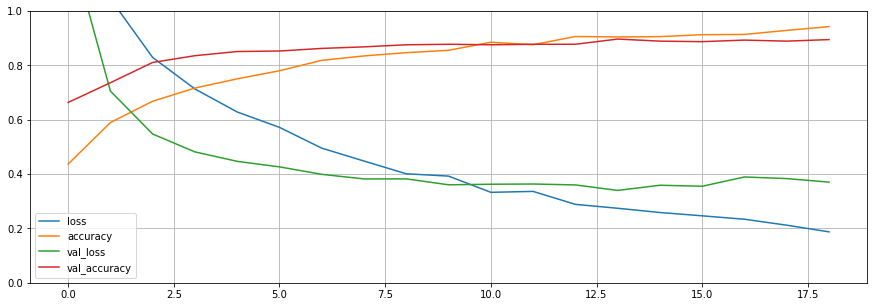

In [49]:
# Graphing model performance on every epoch

pd.DataFrame(history_resnet.history).plot(figsize=(15, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Same as the initial model, we can see that the training loss and acurracy are steadily improving on every epoch. Validation accuracy is also increasing concurrently with the training accuracy, while for validation loss, it seemed to converge at 10th epoch and not improving after 14th epoch (train_loss = 0.27, val_loss = 0.34). This model seemed to be less overfitted that the model before, we'll confirm it by looking at its performance to the test data.

In [50]:
# recalling class_indices

test_ds2.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [51]:
# evaluate model to test set 

train_pred2 = model_resnet.predict(train_ds2)
train_pred2 = np.argmax(train_pred2, axis = -1)
train_true2 = train_df['label']
train_true2 = np.array(train_true2.replace({'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}))


test_pred2 = model_resnet.predict(test_ds2)
test_pred2 = np.argmax(test_pred2, axis = -1)
test_true2 = test_df['label']
test_true2 = np.array(test_true2.replace({'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}))

print('Classification report (Train)')
print(classification_report(train_true2, train_pred2))

print('')

print('Classification report (Test)')
print(classification_report(test_true2, test_pred2))

Classification report (Train)
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       592
           1       0.99      0.99      0.99       599
           2       0.99      1.00      1.00       320
           3       0.99      0.99      0.99       577

    accuracy                           0.99      2088
   macro avg       0.99      0.99      0.99      2088
weighted avg       0.99      0.99      0.99      2088


Classification report (Test)
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       185
           1       0.87      0.87      0.87       188
           2       0.96      0.95      0.95       100
           3       0.94      0.97      0.95       180

    accuracy                           0.92       653
   macro avg       0.93      0.92      0.92       653
weighted avg       0.92      0.92      0.92       653



We see that that the improved model have better overall performance than the initial model in terms of the recall score (recall score for class 1 improved from 0.85--> 0.87, recall score for class 2 improved from 0.88--> 0.95). We'll observe this improvement deeper by looking at the confusion matrix.

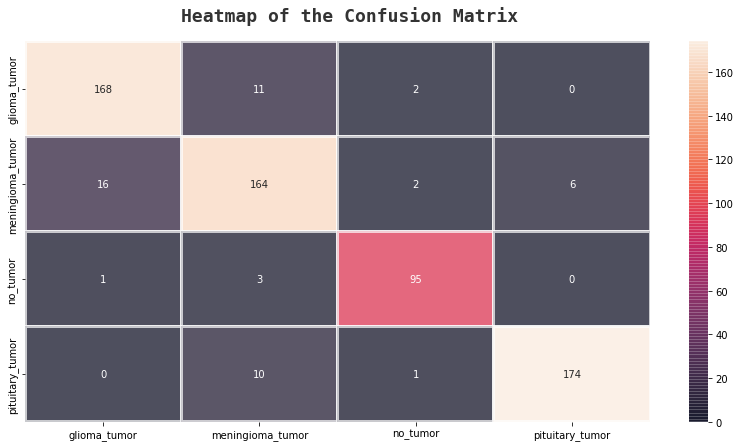

In [52]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(test_pred2,test_true2),ax=ax,xticklabels=labels,yticklabels=labels,annot=True
            ,alpha=0.7,linewidths=2, fmt="d")
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

Note: rows represent predicted class and columns represent true class

On the confusion matrix above, we see that out of 188 samples labeled as meningioma_tumor, 164 are correctly predicted (previous model correctly predict 159). And out of 24 meningioma samples which are wrongly classified, 11 are predicted as glioma tumor (previously: 16), 3 are predicted as no_tumor (previously: 6), and 10 are predicted as pituitary_tumor (previously: 7). This indicates that the current model have less tendency to misclassify meningioma_tumor. We can also see incremental change in True Positive amount (88--> 95) and the decrease of False Negative (12-->5) for 'no_tumor' prediction, which indicates that our model can differentiate a patient who doesn't have tumor more accurately.

# 10 - Model Saving

In [54]:
# Freezing the best model (pretrained ResNet50)

model_resnet.trainable = False

# Save the best model

model_resnet.save('brain_tumor_classifier')

In [55]:
! zip -r brain_tumor_classifier.zip brain_tumor_classifier

  adding: brain_tumor_classifier/ (stored 0%)
  adding: brain_tumor_classifier/assets/ (stored 0%)
  adding: brain_tumor_classifier/variables/ (stored 0%)
  adding: brain_tumor_classifier/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: brain_tumor_classifier/variables/variables.index (deflated 78%)
  adding: brain_tumor_classifier/keras_metadata.pb (deflated 96%)
  adding: brain_tumor_classifier/saved_model.pb (deflated 91%)


# 11 - Model Inference

Save and upload brain tumor (or normal) MRI image from the internet (keyword example: 'meningioma tumor MRI')



Saving meningioma_tumor_1.png to meningioma_tumor_1 (2).png


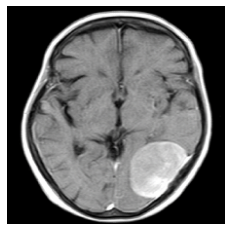

[1]
meningioma_tumor


In [66]:
# Data Inference from random image on the internet

print("Save and upload brain tumor (or normal) MRI image from the internet (keyword example: 'meningioma tumor MRI')")
print('')
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(224,224))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # transform image to array
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])
  classes = model_resnet.predict(images) 
  classes = np.argmax(classes, axis = -1)
  print(classes) 
  if classes[0] == 0:
    print('glioma_tumor')
  elif classes[0] == 1:
    print('meningioma_tumor')
  elif classes[0] == 2:
    print('no_tumor')
  elif classes[0] == 3:
    print('pituitary_tumor')

Save and upload brain tumor (or normal) MRI image from the internet (keyword example: 'meningioma tumor MRI')



Saving normal-brain-MRI.png to normal-brain-MRI.png


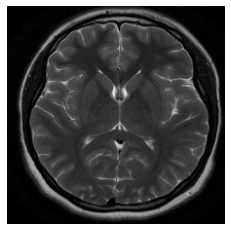

[2]
no_tumor


In [67]:
# Data Inference from random image on the internet

print("Save and upload brain tumor (or normal) MRI image from the internet (keyword example: 'meningioma tumor MRI')")
print('')
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(224,224))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # transform image to array
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])
  classes = model_resnet.predict(images) 
  classes = np.argmax(classes, axis = -1)
  print(classes) 
  if classes[0] == 0:
    print('glioma_tumor')
  elif classes[0] == 1:
    print('meningioma_tumor')
  elif classes[0] == 2:
    print('no_tumor')
  elif classes[0] == 3:
    print('pituitary_tumor')

Save and upload brain tumor (or normal) MRI image from the internet (keyword example: 'meningioma tumor MRI')



Saving pituitary-tumor-mri-1.png to pituitary-tumor-mri-1.png


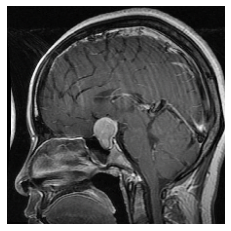

[3]
pituitary_tumor


In [69]:
# Data Inference from random image on the internet

print("Save and upload brain tumor (or normal) MRI image from the internet (keyword example: 'meningioma tumor MRI')")
print('')
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(224,224))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # transform image to array
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])
  classes = model_resnet.predict(images) 
  classes = np.argmax(classes, axis = -1)
  print(classes) 
  if classes[0] == 0:
    print('glioma_tumor')
  elif classes[0] == 1:
    print('meningioma_tumor')
  elif classes[0] == 2:
    print('no_tumor')
  elif classes[0] == 3:
    print('pituitary_tumor')

Save and upload brain tumor (or normal) MRI image from the internet (keyword example: 'meningioma tumor MRI')



Saving glioma-tumor-mri-1.png to glioma-tumor-mri-1.png


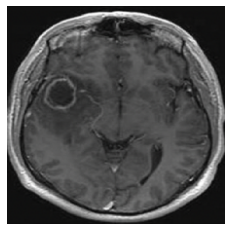

[0]
glioma_tumor


In [70]:
# Data Inference from random image on the internet

print("Save and upload brain tumor (or normal) MRI image from the internet (keyword example: 'meningioma tumor MRI')")
print('')
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(224,224))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # transform image to array
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])
  classes = model_resnet.predict(images) 
  classes = np.argmax(classes, axis = -1)
  print(classes) 
  if classes[0] == 0:
    print('glioma_tumor')
  elif classes[0] == 1:
    print('meningioma_tumor')
  elif classes[0] == 2:
    print('no_tumor')
  elif classes[0] == 3:
    print('pituitary_tumor')

We can see that our model can predict all 4 images downloaded from the internet correctly. 

# 12 - Summary

After proceeding data exploration and model creation for the 'Brain Tumor Classification (MRI)' dataset, these are the things I can conclude:

1. The dataset is comprised of 3264 images of brain tumor Magnetic Resonance Imaging (MRI), with 4 classes of glioma_tumor, meningioma_tumor, no_tumor, and pituitary_tumor. Since amount of data in each class was imbalancely distributed, I chose to rearrange the distribution of train and test set.

2. From the EDA, we see that each types of tumor have more or less balanced proportion except for 'no_tumor' class (a half less than the other classes). Also we see that every types of tumor has different characteristics:
  * glioma : lower density (darker area) with some enhancement on the edge of the tumor
  * meningioma : homogenous enhancement of higher contrast area
  * pituitary tumor : higher contrast area at the middle base of the brain (pituitary location)
  * no tumor : no abnormal enhancement or higher contrast area in the brain

3. From 3264 of total images, I'm taking 80% for train, and the rest 20% for test. 20% of the train data is taken as validation set. To induce better generalization for the model training, I augment the train images with horizontal flip, random rotation, random zoom, and random brightness. Then I rescale the data to by dividing every pixel values by 255.

4. For this case, I'm using Convolutional Neural Network as my image classifier. The first classifier was created from scratch, and for the second one, I'm using pretrained model ResNet50 with some additional layer. It has been shown that the second model has the best performance overall (92% accuracy and average recall score 0.925 for the test set).

5. Because the model is targeted to predict various types of tumor, I chose Recall as the primary evaluation metric. In diagnosing harmful disease such as brain tumor, we need to make False Negative prediction as low as possible (predicting patient with tumor as normal would delay the initial treatment that's needed). Recall score is a good measurement for this case because it represents the proportion of False Negatives (Recall = TP/ TP+FN, the lower the False Negatives the higher the recall).

6. The current CNN model (pretrained ResNet50 with additional layer) shows promising recall score results especially in predicting MRI of glioma_tumor (Train recall 0.99, Test recall 0.91), no_tumor (Train recall 1.00, Test recall 0.95), and pituitary_tumor (Train recall 0.99, Test recall 0.97), the score differences between train and test can still be acceptable as a goodfit for those class. For meningioma tumor, the recall score seemed to be overfitting (Train recall 0.99, Test recall 0.87) although the performance of 0.87 to the test set itself can still be considered as good. From the confusion matrix, we know that the model have little tendency to predict meningioma tumor as either glioma or pituitary tumor.

7. Although the model performs pretty well, surely there're still enough room for improvement. For example, our current performance is still based on little amount of data (we use 3 thousands of images, whereas, state-of-the-art model can use hundred of thousands even millions of images in its training), so there's a big chance that our model doesn't recognized many other variants of MRI images out there. Furthermore, the pretrained model that we use (ResNet50) was basically trained on colored images of everyday objects which probably has different attributes from grayscale MRI images, so if we can find a pretrained model that was trained on medical imaging data, there's a chance that it will lead to better results. We can also improve model performance by experimenting the combinations of different layers and different amount of neurons, also by tweaking the activation function, trying different optimizers with different combinations of learning rate, etc.